## 오토인코더를 이용한 이미지 잡음제거
- U-Net과 비슷하게 정보를 압축하는 인코더
- 압축된 정보를 복원하는 디코더
- 이미지 잡음제거, 인페인팅, 이미지 생성(GAN), 기계 번역

- 가우스 노이즈: 정규 분포를 따르는 노이즈`

In [1]:
import torch
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

from model.autoEncoder import CAE

c:\Users\seung\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### utils

In [2]:
import torch
import numpy as np
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

# scale: 잡음 크기를 조절
def gaussian_noise(x, scale=0.1):
  gaussian_data_x = x + np.random.normal(loc=0, scale=scale, size=x.shape)
  gaussian_data_x = np.clip(gaussian_data_x, 0, 1)
  gaussian_data_x = torch.tensor(gaussian_data_x)
  gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
  return gaussian_data_x

from torch.utils.data.dataset import Dataset

class Denoising(Dataset):
  def __init__(self):
    self.mnist = MNIST(root="./data", train=True, download=True, transform=ToTensor())
    self.data = []

    for i in range(len(self.mnist)):
      noisy_input = gaussian_noise(self.mnist.data[i])
      input_tensor = torch.tensor(noisy_input)
      self.data.append(torch.unsqueeze(input_tensor, dim=0))
  
  def __len__(self):
    return len(self.data)
  def __getitem__(self, i):
    data = self.data[i]
    label = self.mnist.data[i]/255
    return data, label

#### 학습

In [3]:
training_data = MNIST(root="./data", train=True, download=True, transform=ToTensor())
test_data = MNIST(root="./data", train=False, download=True, transform=ToTensor())

device = "cuda" if torch.cuda.is_available() else "cpu"
trainset = Denoising()
train_loader = DataLoader(trainset, batch_size=32)
model = CAE().to(device)

lr = 0.01
optim = Adam(params=model.parameters(), lr=lr)

for epoch in range(1):
  iterator = tqdm.tqdm(train_loader)

  for data, label in iterator:
    optim.zero_grad()
    pred = model(data.to(device))

    loss = nn.MSELoss()(torch.squeeze(pred), label.to(device))
    loss.backward()
    optim.step()
    iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CAE.pth")

C:\Users\seung\AppData\Local\Temp\ipykernel_43380\3784319825.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)
C:\Users\seung\AppData\Local\Temp\ipykernel_43380\3784319825.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noisy_input)
100%|██████████| 1875/1875 [01:23<00:00, 22.58it/s]


#### 평가

C:\Users\seung\AppData\Local\Temp\ipykernel_43380\3784319825.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


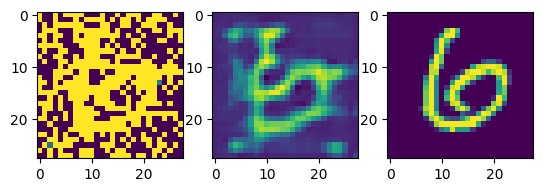

In [5]:
model.cpu()

with torch.no_grad():
  model.load_state_dict(torch.load("CAE.pth", map_location=device))

  img = test_data.data[11]
  gaussian = gaussian_noise(img, scale=100)
  input = torch.unsqueeze(gaussian, dim=0)
  input.type(torch.FloatTensor)
  input.to(device)
  input = torch.unsqueeze(input, dim=0)

  plt.subplot(1, 3, 1)
  plt.imshow(torch.squeeze(gaussian))
  plt.subplot(1, 3, 2)
  plt.imshow(torch.squeeze(model(input)))
  plt.subplot(1, 3, 3)
  plt.imshow(torch.squeeze(img))
  plt.show()